In [7]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time

In [8]:
def succ_prob_calc(B_orig, logicals_in, s_nodes, loss_inds):
    ######################################################
    ## inputs:
    ## B_orig [type: networkx]: stabilizer graph, two kinds of nodes: qubit 1...N and stabilizer s1...s_{Ns}
    ## logicals_in [type: numpy array]: logical operators in every row, columns act on qubits
    ## s_nodes [type: list]: list of stabilizer nodes s1...s_{Ns}
    ## loss_inds [type: numpy array]: index of erased qubits
    #####################
    ## output:
    ## succ_fail [type: binary value]: 0 (failure), 1(success)
    ######################################################
    B = B_orig.copy()
    logicals = np.copy(logicals_in)
    s_nodes_set = set(np.copy(s_nodes))

    Ns_remain = len(s_nodes_set) # number of stabilizer generators
    q_remain = list(set(B.nodes())-s_nodes_set) # number of qubits (anciall+data)
    node_list = list(s_nodes_set) + q_remain  # indices of all nodes in graph
    adj_mat_new = nx.to_numpy_array(B, nodelist = node_list) # adjaceny matrix of stabilizer graph
    Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:] # stabilizer group matrix

    logic_succ = True
    for q in loss_inds:
        ## correct logical operators
        if logicals.ndim == 1:
            if logicals[q]>0:            
                st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                if len(st_ind)>0:
                    logicals = (logicals+Sx_mat[st_ind[0],:]) % 2
                else:
                    logic_succ = False
                    break
        else:
            for i_log in range(np.size(logicals,0)):
                if logicals[i_log,q]>0:            
                    st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                    if len(st_ind)>0:
                        logicals[i_log,:] = (logicals[i_log,:]+Sx_mat[st_ind[0],:]) % 2
                    else:
                        logic_succ = False
                        # logicals[i_log,:] = np.zeros(np.size(logicals,1))
                        break
            if not logic_succ:
                break
            
        ## update stabilizer group
        ## first: update graph
        if q in B:
            sq = [n for n in B.neighbors(q)]
            if len(sq)==1:
                B.remove_nodes_from(sq)
                s_nodes_set -= set(sq)
            elif len(sq)>1:
                double_edgs = []
                for i in range(len(sq)-1):
                    n0 = set(B.neighbors(sq[i]))
                    n1 = set(B.neighbors(sq[i+1]))
                    rep_qs = n0.intersection(n1)
                    q0 = list(set(n0)-rep_qs)
                    q1 = list(set(n1)-rep_qs)
                    double_edgs += [(sq[i], e) for e in q0]
                    double_edgs += [(sq[i], e) for e in q1]
                G = nx.Graph()
                G.add_nodes_from(sq[:-1])
                G.add_edges_from(double_edgs)
                sq_remain = list(s_nodes_set-set(sq))
                for s in sq_remain:
                    G.add_edges_from([(s, e) for e in B.neighbors(s)])
                B = G
                s_nodes_set -= {sq[-1]}

        ## second: update stabilizer group matrix
            Ns_remain = len(s_nodes_set)
            if Ns_remain> 0:
                q_remain = list(set(B.nodes())-s_nodes_set)
                node_list = list(s_nodes_set) + q_remain
                adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                Sx_mat = np.zeros((Ns_remain,N))
                Sx_mat[:,q_remain] = Sx_red
            else:
                Sx_mat = []
                break

    ## check if logical error happens
    if logicals.ndim == 1:
        logic_sum = np.sum(logicals)> 0
    else:
        logic_sum = np.sum(np.sum(logicals,axis=1))> (np.size(logicals,0)-1)
        
    succ_fail = 0 # default value: failure
    if Ns_remain > 0 and logic_sum and logic_succ:
        succ_fail = 1 # success

    return succ_fail

## code breakdown illustration
Here we use 7-qubit code as an example and show how the algorithm performs.

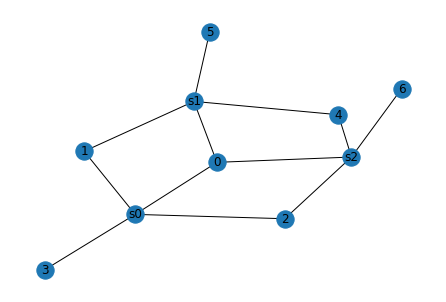

list of erased qubits: [3 0 5]
-------------------------
erased qubit: 3
s0 is applied to log op.
log op. is  [0. 0. 0. 0. 1. 1. 1.]
stabilizer ops. are
[[1. 1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1.]]


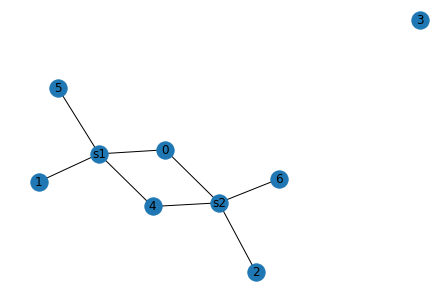

-------------------------
erased qubit: 0
log op. is  [0. 0. 0. 0. 1. 1. 1.]
stabilizer ops. are
[[0. 1. 1. 0. 0. 1. 1.]]


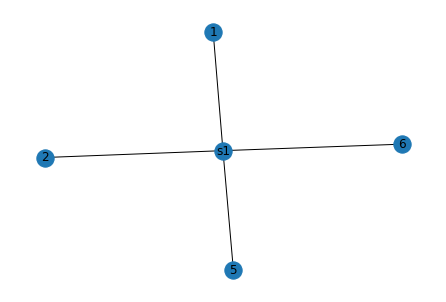

-------------------------
erased qubit: 5
s0 is applied to log op.
log op. is  [0. 1. 1. 0. 1. 0. 0.]
logical error!


In [9]:
## 7-qubit stabilizer matrix
Sx_mat = np.array([[1,1,1,1,0,0,0],\
            [1,1,0,0,1,1,0],\
            [1,0,1,0,1,0,1]])

N = np.size(Sx_mat,1) # number of data qubits 
Ns = np.size(Sx_mat,0) # number of stabilizers 

## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(np.size(Sx_mat,0)):
    qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig,  with_labels=True)
plt.show()
## logical operator
logical = np.ones(N)

p = 0.3 # loss probability
## generate an instance of loss events
loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
print("list of erased qubits:", loss_inds)
print("-------------------------")

B = B_orig.copy()
s_nodes_set = set(np.copy(s_nodes))

Ns_remain = len(s_nodes_set)
q_remain = list(set(B.nodes())-s_nodes_set)
node_list = list(s_nodes_set) + q_remain
adj_mat_new = nx.to_numpy_array(B, nodelist = node_list)
Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:]

logic_succ = True
for q in loss_inds:
    print("erased qubit:", q)
    if logical[q]>0:            
        st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
        if len(st_ind)>0:
            print("s%d is applied to log op." % st_ind[0])
            # print("sum is ", ((logical+Sx_mat[st_ind[0],:]) % 2))
            logical = ((logical+Sx_mat[st_ind[0],:]) % 2)
        else:
            logic_succ = False
            break
           
    print("log op. is ", logical)
    if q in B:
        sq = [n for n in B.neighbors(q)]
        if len(sq)==1:
            B.remove_nodes_from(sq)
            s_nodes_set -= set(sq)
        elif len(sq)>1:
            double_edgs = []
            for i in range(len(sq)-1):
                n0 = set(B.neighbors(sq[i]))
                n1 = set(B.neighbors(sq[i+1]))
                rep_qs = n0.intersection(n1)
                q0 = list(set(n0)-rep_qs)
                q1 = list(set(n1)-rep_qs)
                double_edgs += [(sq[i], e) for e in q0]
                double_edgs += [(sq[i], e) for e in q1]
            G = nx.Graph()
            G.add_nodes_from(sq[:-1])
            G.add_edges_from(double_edgs)
            sq_remain = list(s_nodes_set-set(sq))
            for s in sq_remain:
                G.add_edges_from([(s, e) for e in B.neighbors(s)])
            B = G
            s_nodes_set -= {sq[-1]}
        
        Ns_remain = len(s_nodes_set)
        if Ns_remain> 0:
            q_remain = list(set(B.nodes())-s_nodes_set)
            node_list = list(s_nodes_set) + q_remain
            adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
            Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
            keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,1]
            Sx_red = Sx_red[:,keep_cols]
            q_remain = np.array(q_remain)[keep_cols]
            Sx_mat = np.zeros((Ns_remain,N))
            Sx_mat[:,q_remain] = Sx_red
        else:
            Sx_mat = []
            break
            
        print("stabilizer ops. are")
        print(Sx_mat)
            # print(s_nodes_set,q_remain)

    nx.draw(B,  with_labels=True)
    plt.show()
    print("-------------------------")

## check if logical error happens
logic_sum = np.sum(logical)> 0        
succ_fail = 0 # default value: failure
if Ns_remain > 0 and logic_sum and logic_succ:
    succ_fail = 1 # success
if succ_fail:
    print("success!")
else:
    print("logical error!")


## Example 1: single layer 7-qubit code

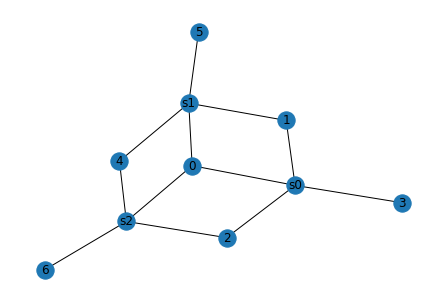

In [10]:
## with logical operator
Sx_mat = np.array([[1,1,1,1,0,0,0],\
            [1,1,0,0,1,1,0],\
            [1,0,1,0,1,0,1]])

N = np.size(Sx_mat,1) # number of data qubits 
Ns = np.size(Sx_mat,0) # number of stabilizers 

## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(np.size(Sx_mat,0)):
    qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig,  with_labels=True)
plt.show()
logical = np.ones(N)

p_list = np.linspace(0.01,0.99,20)
Nrep = 2000 # number of MC iterations
succ_prob = np.zeros(len(p_list))

for i_p, p in enumerate(p_list):
    for i_rep in range(Nrep):
        loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
        succ_prob[i_p] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)
            
succ_prob /= Nrep

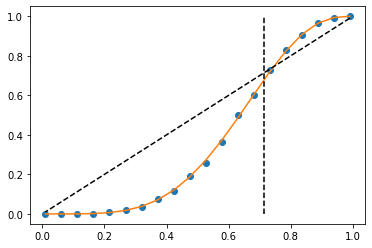

In [11]:
plt.plot(1-p_list,succ_prob,"o")
f = lambda x: x**7 + 7*x**6*(1-x) + 7*3*x**5 * (1-x)**2 #+ 7*5 *x**4 * (1-x)**3
plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-2/7
plt.plot([x0,x0],[0,1],"k--")

## multi-layer

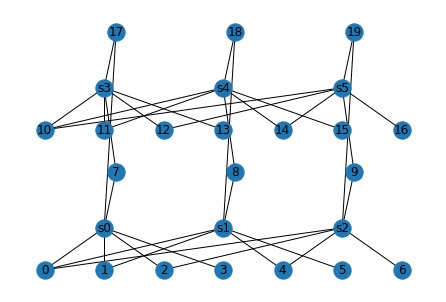

finished L = 2 in 38.1 secs


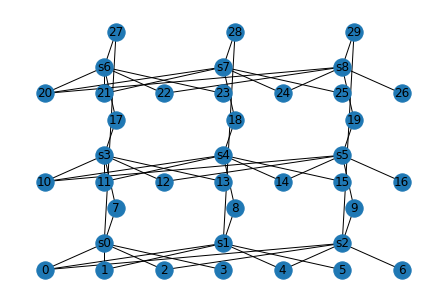

finished L = 3 in 62.5 secs


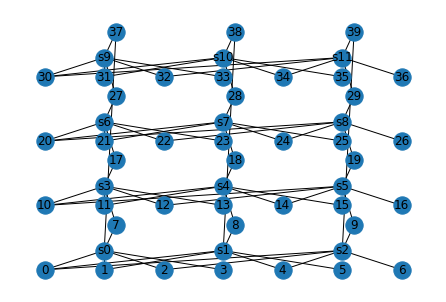

finished L = 4 in 90.6 secs


In [12]:
# in layer stabilizer group
Sx_mat = np.array([[1,1,1,1,0,0,0],\
              [1,1,0,0,1,1,0],\
              [1,0,1,0,1,0,1]])

Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer

Nl_list = np.arange(2,5) # number of layers
p_list = np.linspace(0.01,0.4,20) # list of loss probability
Nrep = 2000 # number of MC iterations
succ_prob_7q = np.zeros((len(p_list),len(Nl_list)))

for i_L, Nl in enumerate(Nl_list):
    tic = time.time()
    # Nl = 3 # number of layers in foliated code
    N = Nl*(Nq_l+Ns_l) # number of data qubits
    Ns = Nl*Ns_l # number of stabilizers
    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)
    for row in range(Ns_l):
        qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs])
    for i_l in range(Nl):
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])

    pos = dict()
    for q in range(N):
        x = q%(Nq_l+Ns_l)
        y = int(q/(Nq_l+Ns_l))
        if x >= Nq_l:
            pos[q] = (2*(x-4)-4.8,y+0.7)
        else:
            pos[q] = (x,y)
    for sq in range(Ns):
        x = sq% Ns_l
        y = int(sq/Ns_l)
        pos["s%d" % sq] = (2*x+1,y+0.3)

    nx.draw(B_orig, pos,  with_labels=True)
    plt.show()

    logical = np.zeros(N)
    for i_l in range(Nl):
        logical[i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = np.ones(Nq_l)

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
            succ_prob_7q[i_p,i_L] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)
    toc = time.time()
    print("finished L = %d in %.1f secs" % (Nl,toc-tic))

succ_prob_7q /= Nrep

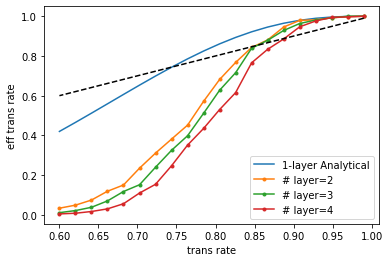

In [13]:
f = lambda x: x**7 + 7*x**6*(1-x) + 7*3*x**5 * (1-x)**2 #+ 7*5 *x**4 * (1-x)**3
plt.plot(1-p_list,f(1-p_list),"-",label="1-layer Analytical")
for i_L, L in enumerate(Nl_list):
    plt.plot(1-p_list,succ_prob_7q[:,i_L]**2,".-", color ="C%d" % (i_L+1), label="# layer=%d" % L)

plt.plot(1-p_list,1-p_list,"k--")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.savefig("7q_tot_prev.pdf")
plt.show()

## Example 2: Toric code

In [64]:
L_list = np.arange(4,12,2) # linear dim of toric code
p_list = np.linspace(0.01,0.99,20)
Nrep = 200
succ_prob_tc = np.zeros((len(p_list),len(L_list)))

for i_L, L in enumerate(L_list):
    tic = time.time()
    
    r1 = L
    r2 = L
    N = 2*r1*r2 # number of data qubits
    Ns = r1*r2 # number of stabilizers

    Sx = np.zeros((r1*r2,2*r1*r2),dtype=int)
    pos = dict()
    for i_y in range(r2):
        for i_x in range(r1):
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
            pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
            pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
            pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
            pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
            pos[2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)#, bipartite=1)
    for row in range(np.size(Sx,0)):
        qs = np.argwhere(Sx[row,:]>0)[:,0]
        B_orig.add_edges_from([("s%d" % row, q) for q in qs])

    logicals = np.zeros((2,2*r1*r2))
    logicals[0,1:2*r1:2] = np.ones(r1) 
    logicals[1,0:2*r1*r2:2*r1] = np.ones(r2) 

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
            succ_prob_tc[i_p,i_L] += succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
           
    toc = time.time()
    print("finished L = %d in %.1f secs" % (L,toc-tic))

succ_prob_tc /= Nrep


finished L = 4 in 13.6 secs
finished L = 6 in 52.4 secs
finished L = 8 in 149.4 secs
finished L = 10 in 357.0 secs


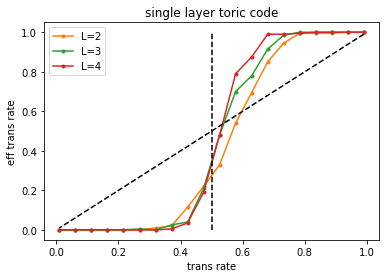

In [65]:
for i_L, L in enumerate(Nl_list):
    plt.plot(1-p_list,succ_prob_tc[:,i_L],".-", color ="C%d" % (i_L+1), label="L=%d" % L)

plt.plot(1-p_list,1-p_list,"k--")
x0 = 0.5  # percolation threshold
plt.plot([x0,x0],[0,1],"k--")
plt.title("single layer toric code")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.show()

## foliated toric code

In [ ]:
Nl_list = np.arange(4,8)
p_list = np.linspace(0.15,0.35,8)
Nrep = 400
succ_prob_3dtc = np.zeros((len(p_list),len(Nl_list)))

for i_L, Nl in enumerate(Nl_list):
    tic = time.time()
    
    r1, r2 = Nl, Nl
    # in layer stabilizer group
    Sx_mat = np.zeros((r1*r2,2*r1*r2),dtype=int)
    for i_y in range(r2):
        for i_x in range(r1):
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx_mat[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1

    Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
    Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer

    # Nl: number of layers in foliated code
    N = Nl*(Nq_l+Ns_l) # number of data qubits
    Ns = Nl*Ns_l # number of stabilizers
    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)
    for row in range(Ns_l):
        qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs])
    for i_l in range(Nl):
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])

    logicals_l = np.zeros((2,2*r1*r2))
    logicals_l[0,1:2*r1:2] = np.ones(r1) 
    logicals_l[1,0:2*r1*r2:2*r1] = np.ones(r2) 

    logicals = np.zeros((2,N))
    for i_l in range(Nl):
        logicals[:,i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logicals_l

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])        
            succ_prob_3dtc[i_p,i_L] += succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)

    toc = time.time()
    print("finished L = %d in %.1f secs" % (Nl,toc-tic))

succ_prob_3dtc /= Nrep

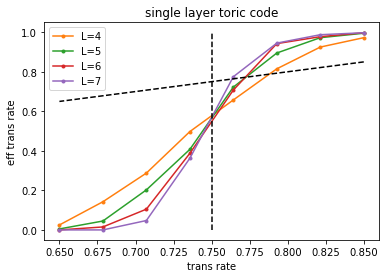

In [6]:
for i_L, L in enumerate(Nl_list):
    plt.plot(1-p_list,succ_prob_3dtc[:,i_L],".-", color ="C%d" % (i_L+1), label="L=%d" % L)

plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-0.25  # percolation threshold
plt.plot([x0,x0],[0,1],"k--")
plt.title("single layer toric code")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.show()